# Parte 2: Trabajando con el problema de arranque en frio de filtrado basado en contenido (Content-Based Filtering)

El `filtrado colaborativo` se basa en las interacciones del usuario con los items (user-item) dentro de una matriz de utilidad. El problema reside en que los nuevos usuarios o los elementos que no cuenten con interacciones registradas van a ser ignoradas por el sistema de recomendacion. A esto se le conoce como el problema de "Arranque en frio". El filtrado basado en contenido es una manera de atacar este problema al generar recomendaciones en interacciones usuario-item.

En el siguiente ejercicio, generaremos recomendaciones tipo item-item utilizando filtrado basado en contenido.

### Paso 1: Importar las librerias necesarias

Se utiizaran los siguientes paquetes de Python:

- [numpy](https://numpy.org/): para calculos cientificos
- [pandas](https://pandas.pydata.org/): para manipulacion de dato
- [scikit-learn](https://scikit-learn.org/stable/): para funciones de machine learning
- [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/): para visualizacion de datos

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns



### Paso 2: Cargando los datos

Construiremos nuestro sistema de recomendacion a partir del supuesto de que conocemos muy poco acerca de nuestros usuarios. No contamos con datos suficientes sobre las interacciones con nuestro sistema como para implementar filtrado colaborativo.

Exploremos el dataset para conocer su estructura y las propiedades con las que podemos trabajar.

In [2]:
import os
import json
DIR = "/Users/juan_arturo_rg/Documents/Big Data/Proyecto/"
os.chdir(DIR)

#movies = pd.read_json("australian_users_items.json")
#movies.head()

from datasets import load_dataset

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_All_Beauty")
print(dataset["full"][0])

#https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023
#https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews
#https://github.com/hyp1231/AmazonReviews2023/tree/main/amazon-c4



Found cached dataset amazon-reviews-2023 (/Users/juan_arturo_rg/.cache/huggingface/datasets/McAuley-Lab___amazon-reviews-2023/raw_meta_All_Beauty/0.0.0/16b76e0823d73bb8cff1e9c5e3e37dbc46ae3daee380417ae141f5e67d3ea8e8)


  0%|          | 0/1 [00:00<?, ?it/s]

{'main_category': 'All Beauty', 'title': 'Howard LC0008 Leather Conditioner, 8-Ounce (4-Pack)', 'average_rating': 4.8, 'rating_number': 10, 'features': [], 'description': [], 'price': 'None', 'images': {'hi_res': [None, 'https://m.media-amazon.com/images/I/71i77AuI9xL._SL1500_.jpg'], 'large': ['https://m.media-amazon.com/images/I/41qfjSfqNyL.jpg', 'https://m.media-amazon.com/images/I/41w2yznfuZL.jpg'], 'thumb': ['https://m.media-amazon.com/images/I/41qfjSfqNyL._SS40_.jpg', 'https://m.media-amazon.com/images/I/41w2yznfuZL._SS40_.jpg'], 'variant': ['MAIN', 'PT01']}, 'videos': {'title': [], 'url': [], 'user_id': []}, 'store': 'Howard Products', 'categories': [], 'details': '{"Package Dimensions": "7.1 x 5.5 x 3 inches; 2.38 Pounds", "UPC": "617390882781"}', 'parent_asin': 'B01CUPMQZE', 'bought_together': None, 'subtitle': None, 'author': None}


In [3]:
products = pd.DataFrame(dataset["full"])

In [4]:
def get_attribute_as_column(db, attribute):

  r = []
  for i in db.index:
    try:
      r.append(json.loads(db.details[i])[attribute])
    except:
      r.append(np.nan)
  return r

In [5]:
a = 'Item Form'
products[a] = get_attribute_as_column(products, a)

Podemos ver que el dataset cuenta con el id de la pelicula, el titulo y los generos asociados a dicha pelicula.

### Paso 3: Limpieza y Exploracion de los Datos

Generaremos las columnas de los atributos que nos importan haciendo la limpieza

In [8]:
variables_to_use = ['Item Form', 'Material', 'Hair Type', 'Unit Count', 'Number of Items', 'Material Feature', 'Skin Type']

In [9]:
for a in variables_to_use:
  products[a] = get_attribute_as_column(products, a)

#### Cuales son las formas de items mas comunes?


In [10]:
from collections import Counter

items_form = Counter(g for g in products['Item Form'])
print(f"Existen {len(items_form)} tipos de items.")
items_form

print("Top 10 de generos de peliculas: \n", items_form.most_common(10))

Existen 737 tipos de items.
Top 10 de generos de peliculas: 
 [(nan, 80151), ('Cream', 4272), ('Liquid', 3623), ('Gel', 3386), ('Pair', 1802), ('Powder', 1783), ('Spray', 1719), ('Oil', 1649), ('Bar', 1345), ('Lotion', 1026)]



Utilizemos barplot para visualizar esta informacion.

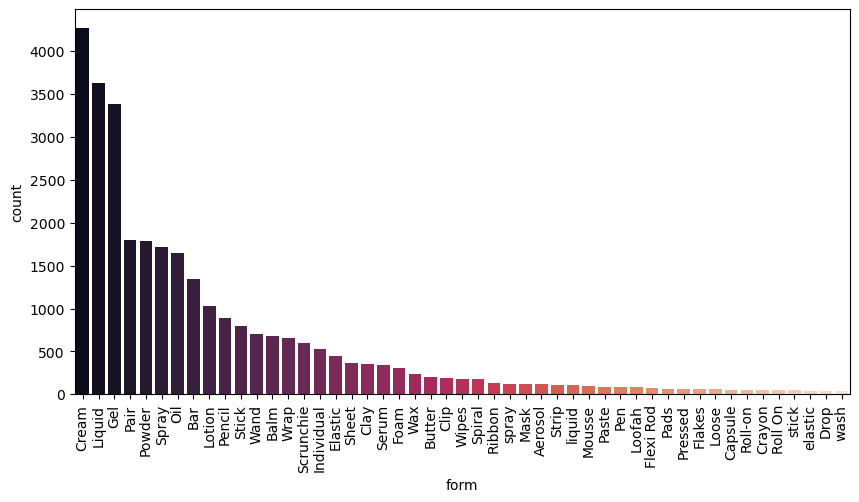

In [11]:
items_form_df = pd.DataFrame([items_form]).T.reset_index()
items_form_df.columns = ['form', 'count']
items_form_df = items_form_df.sort_values(by='count', ascending=False)
items_form_df.reset_index(inplace=True)

items_form_df = items_form_df.iloc[0:50]

plt.figure(figsize=(10,5))
sns.barplot(x='form', y='count', data=items_form_df, palette='rocket')
plt.xticks(rotation=90)
plt.show()

Existen 1388 tipos de materiales.
Top 10 de generos de peliculas: 
 [(nan, 81648), ('Human Hair', 8689), ('Synthetic', 4597), ('Plastic', 1774), ('Acrylic', 1426), ('Human', 976), ('Metal', 939), ('Cotton', 766), ('Rubber', 578), ('Faux Mink', 567)]


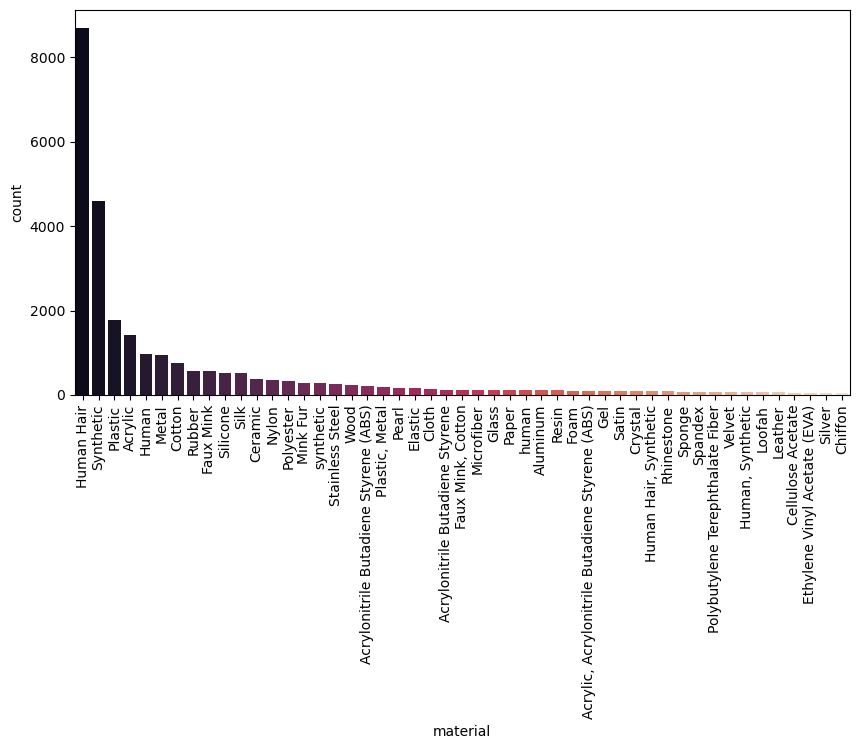

In [12]:
from collections import Counter

materials = Counter(g for g in products['Material'])
print(f"Existen {len(materials)} tipos de materiales.")
materials

print("Top 10 de generos de peliculas: \n", materials.most_common(10))

materials_df = pd.DataFrame([materials]).T.reset_index()
materials_df.columns = ['material', 'count']
materials_df = materials_df.sort_values(by='count', ascending=False)
materials_df.reset_index(inplace=True)

materials_df = materials_df.iloc[0:50]

plt.figure(figsize=(10,5))
sns.barplot(x='material', y='count', data=materials_df, palette='rocket')
plt.xticks(rotation=90)
plt.show()

Ahora limpiemos nuestro dataset al eliminar todas las peliculas que contengan un `null` en el año.

In [13]:
c = products['Material'].replace(np.nan, '')

for i in variables_to_use:
  c = c + products[i].replace(np.nan, '')

In [14]:
products['filter'] = c.replace('', np.nan)

In [15]:
products = products[~products['filter'].isnull()]
print(f"Total de peliculas despues de eliminar aquellas con null en el las varaibles a analizar:: {products['title'].nunique()}")


Total de peliculas despues de eliminar aquellas con null en el las varaibles a analizar:: 72466


Tambien limpiaremos todas las columnas de los productos que no esten en el arreglo de los 20 atributos mas comunes para evitar una matriz enorme (y sobre entrenada)

In [16]:
#Filtering only top items (to avoid creatign extra categories for the model)

def top_de_variable(db, column, top_n):

  counter_result = Counter(g for g in db[column])
  counter_result_df = pd.DataFrame([counter_result]).T.reset_index()
  counter_result_df.columns = [column, 'count']
  counter_result_df = counter_result_df[~counter_result_df[column].isnull()]
  counter_result_df = counter_result_df.sort_values(by='count', ascending=False)
  counter_result_df.reset_index(inplace=True)

  counter_result_df = counter_result_df.iloc[0:top_n]

  return counter_result_df


filter_top = False
for i in variables_to_use:

  f = top_de_variable(products, i, 20)

  filter_top = filter_top + products[i].isin(f[i])

In [17]:
products = products[filter_top]
print(f"Total de peliculas despues de eliminar aquellas con que no estaban en el top 20 de las variables mas comnunes quedan:: {products['title'].nunique()}")

Total de peliculas despues de eliminar aquellas con que no estaban en el top 20 de las variables mas comnunes quedan:: 68164


### Paso 4: Transformando los datos

Para construir un sistema de recomendacion con filtrado basado en contenido necesitamos preparar nuestro dataset de forma tal que las filas representen los items y las columnas las caracteristicas

In [19]:
product_features = pd.DataFrame()

for column in variables_to_use:

  counter_result = Counter(g for g in products[column])
  counter_result_df = pd.DataFrame([counter_result]).T.reset_index()
  counter_result_df.columns = [column, 'count']
  counter_result_df = counter_result_df[~counter_result_df[column].isnull()]
  counter_result_df = counter_result_df.sort_values(by='count', ascending=False)
  counter_result_df.reset_index(inplace=True)
  counter_result_df = counter_result_df.iloc[0:20]

  attributes = list(counter_result_df[column].values)

  for g in attributes:
    try:
      products[g] = products[column].transform(lambda x: int(x == g))
    except:
      products[g] = 0


  product_features = pd.concat([products[attributes], product_features], axis=1)

product_features.reset_index(inplace=True)
products.reset_index(inplace=True)
product_features.head()



/var/folders/f1/n63zt7151hb91yx0gw6r_3xr0000gn/T/ipykernel_54570/1416780769.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  product_features.reset_index(inplace=True)
/var/folders/f1/n63zt7151hb91yx0gw6r_3xr0000gn/T/ipykernel_54570/1416780769.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  products.reset_index(inplace=True)


,index,All,Sensitive,Dry,Acne Prone,Oily,Normal,Combination,Mature,"Sensitive, Dry",...,Stick,Wand,Balm,Wrap,Scrunchie,Individual,Elastic,Sheet,Clay,Serum
0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


El dataframe `product_features` esta listo y contiene los datos que nos interesan. Ahora debemos de construir nuestro sistema de recomendacion.

### Step 5: Construyendo un sistema de recomendacion de "Peliculas Parecidas" utilizando similitud Coseno

Para construir este sistema de recomendacion item-item utilizaremos una metrica llamada similitud coseno `cosine similarity`.

La similitud Coseno se basa en el coseno del angulo entre dos vectores (c.e., $A$ y $B$). Entre mas pequeño es el angulo, mayor es la similitud entre los vectores, y se calcula de la siguiente forma:

$$\cos(\theta) = \frac{A\cdot B}{||A|| ||B||}$$

En este ejercicio, utilizaremos la funcion de scikit-learn de `cosine_similarity` para generar la matriz de similitud de tipo $(n_{\text{movies}}, n_{\text{movies}})$. Esta matriz nos permitira extraer peliculas que sean parecidas a nuestra pelicula de interes.

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(product_features, product_features)
print(f"Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: {cosine_sim.shape}")

Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: (69199, 69199)


Esto nos indica que al evaluar la similitud de coseno del dataframe `product_features` en la funcion `cosine_similarity()` obtenemos una matriz de similitud del tipo $(n_{\text{movies}}, n_{\text{movies}})$.

Esta matriz contiene valores entre 0 y 1 que representan el angulo de similaridad entre las peliculas en los ejes x , y.


### Desarrollando una funcion que encuentre productos similares


In [21]:
from fuzzywuzzy import process

def encuentra_producto(title):
    all_titles = products['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

/Users/juan_arturo_rg/anaconda3/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Probemos la funcionalidad de la funcion `encuentra_pelicula()` al escribir equivocadamente la pelicula `Jumanji`

In [22]:
title = encuentra_producto('White Pink Toothbrush')
print(f"El titulo correcto del producto es: {title}:")

El titulo correcto del producto es: Pro by Oral-B 2500 3D White Pink Toothbrush with Case:


Ahora que ya no nos preocupamos por escribir mal el titulo del producto, lo que nos interesa es encontrar recomendaciones relevantes a partir del que deseamos.


In [23]:
products_idx = dict(zip(products['title'], list(products.index)))
idx = products_idx[title]
print(f"El indice del producto {title} en la matriz product_idx es: {idx}")

El indice del producto Pro by Oral-B 2500 3D White Pink Toothbrush with Case en la matriz product_idx es: 69194


Ahora tratemos de encontrar los 10 productos mas similares.

In [26]:
numero_recomendaciones=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(numero_recomendaciones+1)]
similar_products = [i[0] for i in sim_scores]

`similar_products` es un arreglo de indices que representa el top 10 de recomendaciones a partir del producto elegido

In [28]:
print(f"Por que el producto {title}, te pueden interesar los siguientes {numero_recomendaciones} productos:")
products['title'].iloc[similar_products]

Por que el producto Pro by Oral-B 2500 3D White Pink Toothbrush with Case, te pueden interesar los siguientes 10 productos:


68930    10set (3pcs/set) Grooming Brow Stencil Kit Pai...
67178    Bogobrush Reusable Toothbrush and Stand Made w...
66829    Oral-B Vitality Dual Clean Rechargeable Electr...
66653    Oral-B Precision Clean Electric Toothbrush, EA...
64933    Reusable Makeup Eraser Pads | 4 Pack Large Eco...
64592    Malydyox 3-in-1 Waterproof Sonic Electric Toot...
63452    4 Pieces Soft Toothbrush Micro Nano Toothbrush...
63137    LNBORZIZN Cat Toothbrush Puppy Toothbrush Disp...
62911    Extra Soft Toothbrush with 20000 Soft Bristles...
61764    Vsmile Sonic Electric Toothbrushes for Adults ...
Name: title, dtype: object

Podemos probar nuestro sistema con otros titulos de peliculas.

In [35]:
def obtener_recomendaciones_basadas_contenido(title_string, numero_recomendaciones=10):
    title = encuentra_producto(title_string)
    idx = products_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(numero_recomendaciones+1)]
    similar_products = [i[0] for i in sim_scores]
    print(f"Las productors recomendados con base en \n\t{title} \n son:")
    print(products['title'].iloc[similar_products])

In [36]:
obtener_recomendaciones_basadas_contenido('Eye Shadow', 5)

Las productors recomendados con base en 
	Josie Maran Coconut Watercolor Eye Shadow in 'Rio de Rose Gold' 
 son:
1166    Chin Up Patch | V line | Double Chin Reducer |...
372                               Advanced Cleansing Silk
371                            Kate Brown Shade Eyes Br-2
358     LOL Cosmetics Palette Long Lasting Eyeshadow M...
449     Eye Makeup Kit,Includes Smoky Cat Eyeliner Ste...
Name: title, dtype: object


In [40]:
obtener_recomendaciones_basadas_contenido('Sun Stick', 5)

Las productors recomendados con base en 
	Mac Cosmetics Studio Fix Matte Foundation Stick - NW13 
 son:
130    QrBxa 20 Pcs/Set Tattoo Lipstick Cotton Swab L...
315    HAIR CHALKS SET: 6 Colors Temporary Hair Color...
335    Technic Highlights Stick Cream Highlighter 7.3...
376      Beauty 21 Cosmetics Clipc32 Beauty 21 Cosmetics
467    Maybelline Vivid Matte Lipstick Number 35, Reb...
Name: title, dtype: object


In [39]:
obtener_recomendaciones_basadas_contenido('Shampoo', 5)

Las productors recomendados con base en 
	NOOK NO YELLOW"THE SERVICE COLOR" SILVER SHAMPOO 300 ML. 
 son:
180     Sally Hansen Nail Prisms - Golden Tourmaline #29
233    Ohana Mahaalo Silky & Moist Fragrance Shampoo ...
321         LeChat Dare To Wear Nail Polish - (Plumeria)
439    Kao Merit Shampoo Refill Net Wt.11.49 floz/340...
461    N°5 Eau De Parfum Spray for Women, 3.4 Ounce/1...
Name: title, dtype: object


# Recomendaciones finales:

## Repite todos los pasos contenidos en este proyecto con el dataset de tu proyecto.